# Import Data Analytic Tool/Package

In [ ]:
#import libraries for data analytics
import pandas as pd
import numpy as np
import random
import itertools
import math

In [ ]:
#import libraries for visualization
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Dataset: Reading dataset based on month of June 2016

In [ ]:
#creates a dataframe to read the data
df = pd.read_csv('data06.csv')
#preview  what different columns in database is like
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1,N,-73.981636,40.670242,1,22.0,0.5,0.5,4.00,0.0,0.3,27.30
1,3,2,2016-06-09 21:06:36,2016-06-09 21:13:10,1,1.26,-73.994316,40.751072,1,N,-74.004234,40.742168,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
2,4,2,2016-06-09 21:06:36,2016-06-09 21:36:10,1,7.39,-73.982361,40.773891,1,N,-73.929466,40.851540,1,26.0,0.5,0.5,1.00,0.0,0.3,28.30
3,5,2,2016-06-09 21:06:36,2016-06-09 21:23:23,1,3.10,-73.987106,40.733173,1,N,-73.985909,40.766445,1,13.5,0.5,0.5,2.96,0.0,0.3,17.76
4,6,2,2016-06-09 21:06:36,2016-06-09 21:19:21,1,2.17,-73.995201,40.739491,1,N,-73.993202,40.762642,1,10.5,0.5,0.5,2.36,0.0,0.3,14.16


As evident from the dataset, the temporal data is listed as data and time. We will need to extract the time by the hour to calculate temporal trends in our EDA analysis for the month of June 2016. 

# Create an SQL database

In [ ]:
#import necessary library
from sqlalchemy import create_engine
# create a sql dataset
nyc_database = create_engine('sqlite:///nyc_database.db')

We will first attempt to process the data to only show pickup and dropoff time as the hour. The unnecessary elements (such as date and minutes) will be removed.

In [ ]:
#sequentially read csv file as the file is rather large
j, chunksize = 1, 100000

#commence for loop within dataframe, and to read within chunks
for df in pd.read_csv('data06.csv', chunksize=chunksize, iterator=True):
        df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns})    #removes all _ within dataframe
        df['pickup_hour'] = [x[11:13] for x in df['tpep_pickup_datetime']]      #tpep_pickup_datetime is now renamed as pickup_hour, information on date and minutes is removed  
        df['dropoff_hour'] = [x[11:13] for x in df['tpep_dropoff_datetime']]    #tpep_dropoff_datetime is now renames as dropoff_hour, information on date and minutes is removed
        df.index += j    #axis labels of df to be 1
        df.to_sql('table_record', nyc_database, if_exists='append')   #write records stored in dataframe to the SQL database 'nyc_database', under table_record
        j = df.index[-1] + 1   #ensures all elements are covered
del df

# Exploratory Data Analysis

## Selecting threshold distance for short and long distance trips

We will now generate summary statistics of distance for trip records. 

In [ ]:
#creates new dataframe which shows the trip distance from original df
df_dist = pd.read_sql_query('SELECT trip_distance FROM table_record', nyc_database)

#shows summary statistics of data, apply function to remove scientific notation
df_dist['trip_distance'].describe().apply(lambda x: format(x, 'f'))

count    11129299.000000
mean            3.045513
std            21.836122
min             0.000000
25%             1.000000
50%             1.720000
75%             3.240000
max         71732.700000
Name: trip_distance, dtype: object

As it takes about 30 miles to travel across the entirety of New York and not interested in looking at trips beyond the city, we will be looking at trip records which do not exceed 100 miles. 

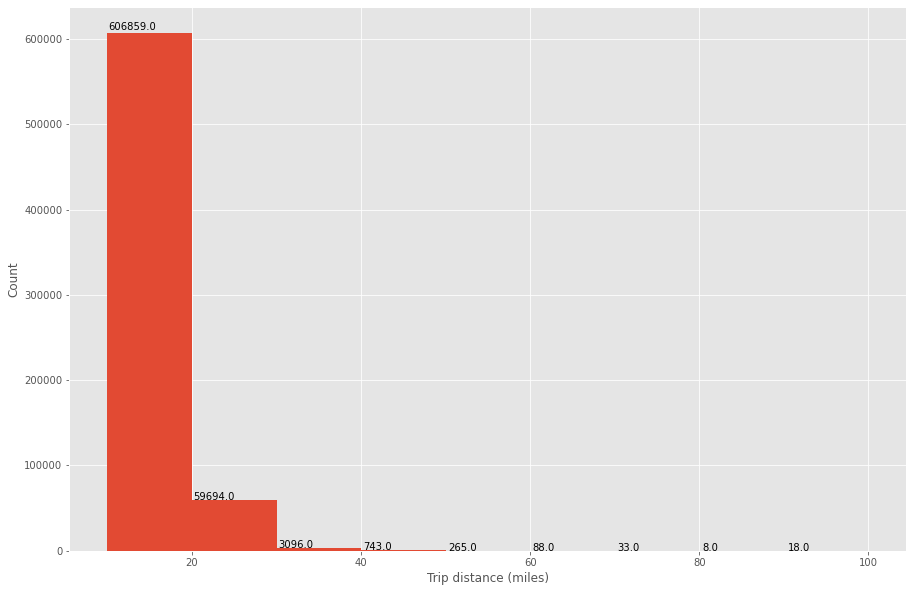

In [ ]:
#specify bins in which we would like to see the x-axis showing 
bins=[10,20,30,40,50,60,70,80,90,100]
#create histogram based on trip_distance
ax = df_dist['trip_distance'].hist(bins=bins, figsize=(15,10))

#annotates number of observations and counts for each distance interval
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
#labels x and y axis
ax.set_xlabel("Trip distance (miles)")
ax.set_ylabel("Count")

#displays plot
plt.show()


We will now look at data from 0-40 miles in detail to determine the threshold distance for short and long distance trips. 

In [ ]:
#creates list of values from 1 to 40
bins2= np.arange(1,41).tolist()
print(bins2)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


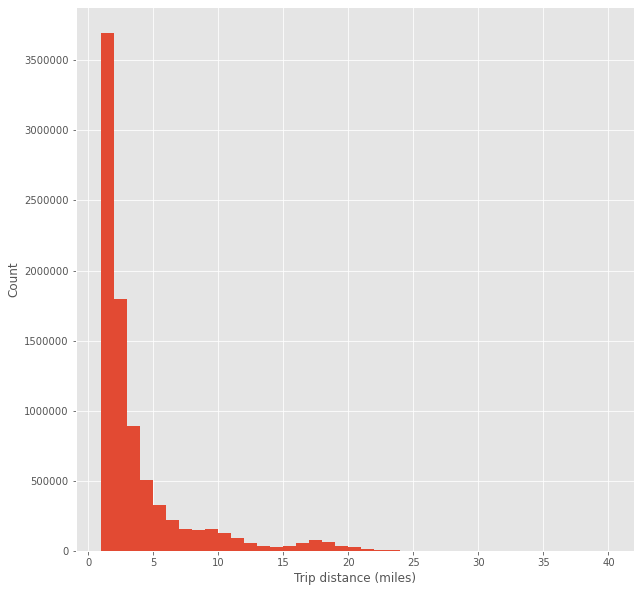

In [ ]:
#specify bins in which we would like to see the x-axis showing 
bins= bins2
#create histogram based on trip_distance
ax = df_dist['trip_distance'].hist(bins=bins, figsize=(10,10))
    
#labels x and y axis
ax.set_xlabel("Trip distance (miles)")
ax.set_ylabel("Count")
#disable scientific notation for axis
ax.ticklabel_format(style='plain')    

#shows plot
plt.show()

As evident from the more detailed histogram above, most trips are made within 24 miles. As such, short distance trips are defined as 24 miles and less and long distance trips are defined as 24 miles and more. 

## Chart radial time plot for short and long distance trips

To characterise the temporal attributes of short and long distance trips for June 2016, we first define dataframes for short and long distance trips. 

In [ ]:
# select short distance trips (<24m) as df_short and long distance trips(>=24m) as df_long using SQL query
df_shortdist = pd.read_sql_query('SELECT pickup_hour AS PUtime, \
                                 dropoff_hour AS DOtime, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance < 24 \
                                 GROUP BY pickup_hour, dropoff_hour', nyc_database)    
df_longdist = pd.read_sql_query('SELECT pickup_hour AS PUtime, \
                                 dropoff_hour AS DOtime, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance >= 24 \
                                 GROUP BY pickup_hour, dropoff_hour', nyc_database)

In [ ]:
#merge dataframe for short distance trips based on pickup and dropoff time and rename the columns  
df = df_shortdist.merge(df_longdist, on=["PUtime", "DOtime"], suffixes=["_shortdist", "_longdist"]) \
                     .rename(columns={"count_shortdist":"short trips", "count_longdist":"long trips", \
                                 "PUtime":"pickup time", "DOtime":"dropoff time"})

#sort by pickup time and aggregate values as sum of observations of short and long distance trips made
df_PU = df.groupby(["pickup time"], as_index=False) \
          .agg({'short trips': 'sum', 'long trips':'sum'}) \
          .sort_values(by="pickup time")
#sort by dropoff time and aggregate values as sum of observations of short and long distance trips made
df_DO = df.groupby(["dropoff time"], as_index=False) \
          .agg({'short trips': 'sum', 'long trips':'sum'}) \
          .sort_values(by="dropoff time")

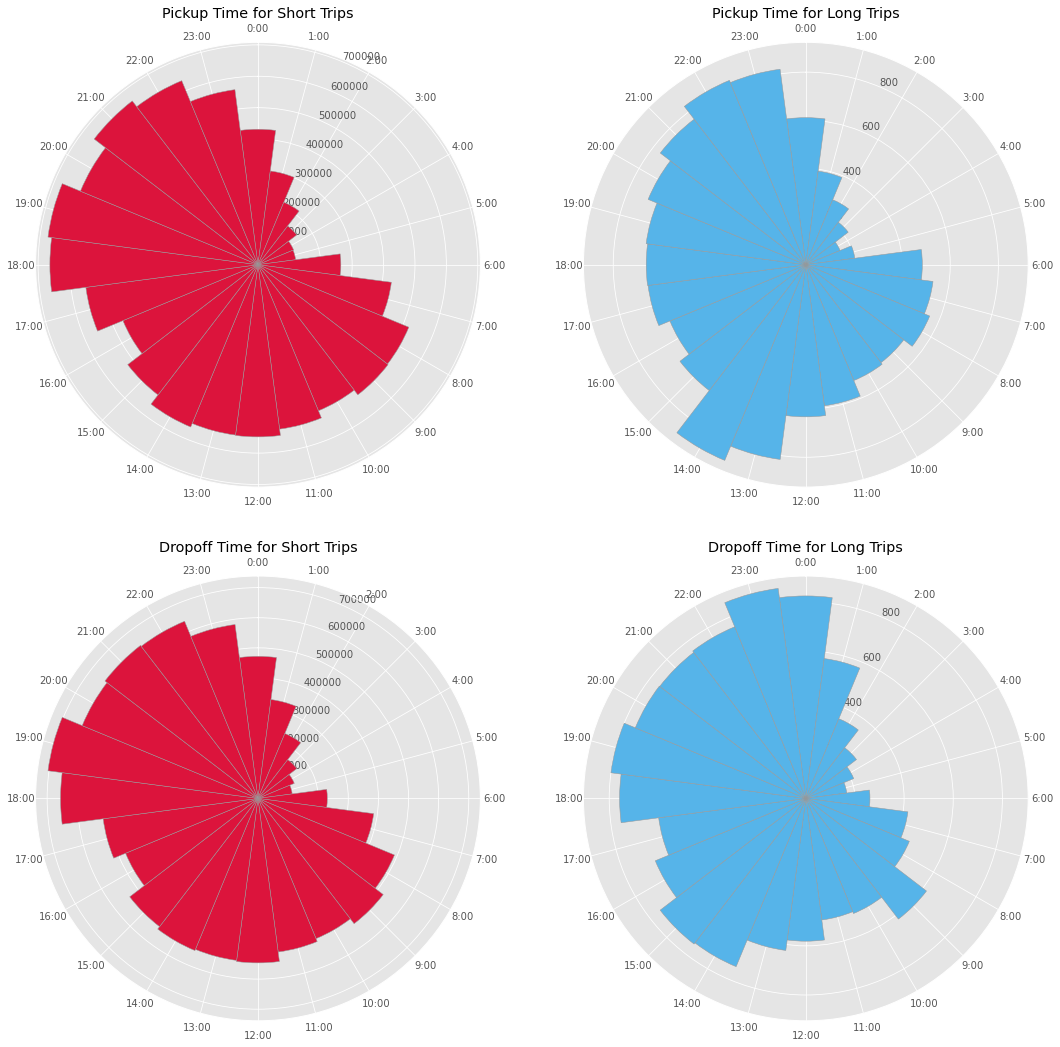

In [ ]:
def plt_clock(ax, radii, title, color):
    """Creates the basis of radial time plot, where the total number of observations can be made within 24 hours temporal sequence. 
            Specifies the theta/ angle for all hours
            Specifies size of each bin 
            Specifies clockwise direction of radial time plot
            Specifies label to be made on each time period
    """
    N = 24
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)


    # width of each bin on the plot
    width = (2*np.pi) / N
    
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # set the lable go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set the label
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

def diff_short_long_trip_on_time():
    """Creates function which shows radial time plot for short and long distance trips based on data given. 
        Creates a two by two table for four different radial plots
        Creates radial plots according to dataframe indicated
    """
    
    #creates a 2 by 2 table for us to insert radial time plot for pickup/dropoff for short and long distance trips
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
    
    #For first radial plot on the left, create one for Pickup time for short trips
    ax = plt.subplot(2,2,1, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_PU['short trips'].tolist(), dtype="int64")
    title = "Pickup Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    #For first radial plot on the right, create one for Pickup time for long trips
    ax = plt.subplot(2,2,2, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_PU['long trips'].tolist(), dtype="int64")
    title = "Pickup Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

    #For second radial plot on the left, create one for Dropoff time for short trips
    ax = plt.subplot(2,2,3, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_DO['short trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    #For second radial plot on the right, create one for Dropoff time for long trips
    ax = plt.subplot(2,2,4, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_DO['long trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

#show the different radial time plots
diff_short_long_trip_on_time()